In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import models
import os
import random
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

In [ ]:
base_model = models.resnet50(pretrained=True)

num_ftrs = base_model.fc.in_features
base_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Linear(512, 28),  # Update output layer to 17 classes
    # nn.Softmax(dim=1)    # Softmax for multi-class classification
)

device = 'mps' if torch.backends.mps.is_available() else 'cpu'
if torch.backends.mps.is_available(): print("yes")
model = base_model.to(device)

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# if torch.cuda.is_available(): print("CUDA available, using GPU")
# model = base_model.to(device)

yes


In [3]:
# Define dataset paths and data augmentations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset paths
train_dir = r'train'  # Specify the path to your train dataset folder
test_dir = r'test'    # Specify the path to your test dataset folder

# Use ImageFolder to load the dataset
train_dataset = ImageFolder(root=train_dir, transform=train_transform)
test_dataset = ImageFolder(root=test_dir, transform=test_transform)

# Split the dataset into train and validation sets (80-20 split)
train_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_set, val_set = random_split(train_dataset, [train_size, val_size])

In [4]:
# Create Data Loaders for training, validation, and test sets
batch_size = 16
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(train_set)}")
print(f"Validation samples: {len(val_set)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 1982
Validation samples: 350
Test samples: 236


In [5]:
# Compile the model (Choose CrossEntropyLoss for multi-class classification)
criterion = nn.CrossEntropyLoss()

# Use a fixed learning rate (e.g., 0.001) and optimizer
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Function to train and evaluate the model
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, device, epochs=10):

    for epoch in range(epochs):
        # Training phase
        model.train()
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_accuracy = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = 100 * correct_val / total_val
        print(f"Epoch {epoch+1}/{epochs} - Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%")

    return train_accuracy, val_accuracy

# Train the model with fixed learning rate
epochs = 15
train_acc, val_acc = train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, device, epochs)

# Save the best model
torch.save(model.state_dict(), 'plant_disease_model.pth')


Epoch 1/15 - Training Accuracy: 18.31%, Validation Accuracy: 23.71%
Epoch 2/15 - Training Accuracy: 31.99%, Validation Accuracy: 33.43%
Epoch 3/15 - Training Accuracy: 40.51%, Validation Accuracy: 39.14%
Epoch 4/15 - Training Accuracy: 47.83%, Validation Accuracy: 46.29%
Epoch 5/15 - Training Accuracy: 55.15%, Validation Accuracy: 52.00%
Epoch 6/15 - Training Accuracy: 60.60%, Validation Accuracy: 56.57%
Epoch 7/15 - Training Accuracy: 67.31%, Validation Accuracy: 58.00%
Epoch 8/15 - Training Accuracy: 71.19%, Validation Accuracy: 61.14%
Epoch 9/15 - Training Accuracy: 75.83%, Validation Accuracy: 57.71%
Epoch 10/15 - Training Accuracy: 78.25%, Validation Accuracy: 61.71%
Epoch 11/15 - Training Accuracy: 80.42%, Validation Accuracy: 64.29%
Epoch 12/15 - Training Accuracy: 83.00%, Validation Accuracy: 64.00%
Epoch 13/15 - Training Accuracy: 85.42%, Validation Accuracy: 63.43%
Epoch 14/15 - Training Accuracy: 86.53%, Validation Accuracy: 62.29%
Epoch 15/15 - Training Accuracy: 89.25%, Va

In [5]:
# Load the saved model
model.load_state_dict(torch.load('plant_disease_model.pth'))
model.eval()

# Evaluate the model on the test set
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

test_accuracy = evaluate_model(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")

/var/folders/k3/p95tbycx1gs7xtdqg7b4ym3h0000gn/T/ipykernel_27030/1691425611.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('plant_disea

Test Accuracy: 60.59%


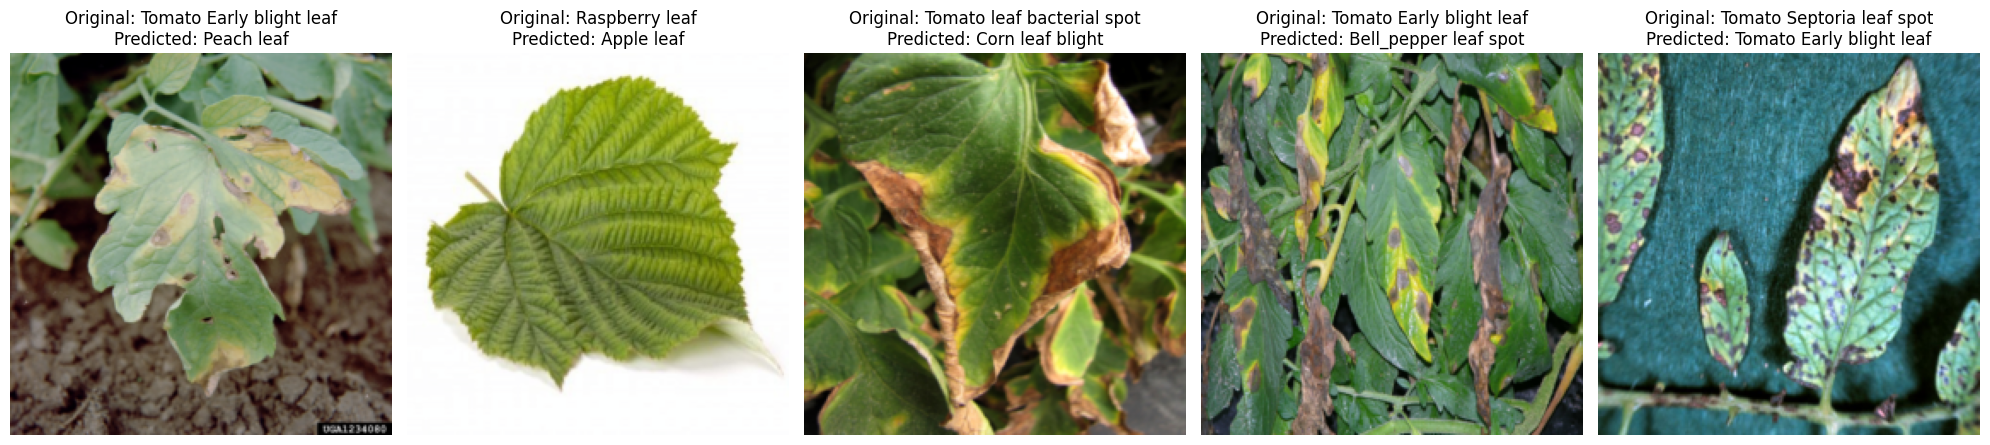

In [20]:
import random

def show_predictions(model, test_loader, device, class_names, num_images=5):
    model.eval()
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))

    all_images = []
    all_labels = []
    all_predictions = []

    # Collect all images, labels, and predictions
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_images.extend(inputs.cpu())  # Store images as CPU tensors
            all_labels.extend(labels.cpu().numpy())  # Store original labels
            all_predictions.extend(predicted.cpu().numpy())  # Store predicted labels

    # Randomly sample `num_images` to display
    sampled_indices = random.sample(range(len(all_images)), num_images)
    
    for idx, ax in zip(sampled_indices, axes):
        img = all_images[idx].numpy().transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Un-normalize
        img = np.clip(img, 0, 1)  # Clip values to ensure they are between 0 and 1

        original_label = class_names[all_labels[idx]]
        predicted_label = class_names[all_predictions[idx]]

        ax.imshow(img)
        ax.set_title(f"Original: {original_label}\nPredicted: {predicted_label}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to display test images and their labels
show_predictions(model, test_loader, device, class_names, num_images=5)
